In [1]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

import zipfile
from read_roi import read_roi_zip
import read_roi
from collections import OrderedDict

from skimage.io import imread, imshow
from skimage import *

In [6]:
# initial value
imageSize=1024 
channel = 3
types = 'Hemorrhage'
##### Making image and mask data for training
def making_data(imageSize=imageSize, channel= 3, types = 'Hemorrhage'):
    imgPath = './{}/image'.format(types)
    roiPath = './{}/roi'.format(types)
    savePath = './{}/npy'.format(types) 
    imgList= sorted(glob.glob(imgPath+'/*'))

    imgnpy = np.zeros((len(imgList),imageSize,imageSize,channel), dtype=np.uint8)
    msknpy = np.zeros((len(imgList),imageSize,imageSize,channel), dtype=np.uint8) 

    print('numpy shape= image: {}, mask: {}'.format(imgnpy.shape, msknpy.shape))  #Checking shape of arrays
    print('Start data processing')
    # input each image and mask from roi file to empty array
    for dl in range(len(imgList)):

        file_num= imgList[dl].split('/')[-1].split('.')[0]
    #     print('Input data {} to array layer {}'.format(file_num, dl))
############################
# crop and resize
        img = cv2.imread(imgList[dl], 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        origin_img = img.copy()
        origin_shape = img.shape
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray[gray>2] = 255
        gray[gray<=2] = 0
        
        _, contours, hierachy = cv2.findContours(gray, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        
        areas=[]
        for cnt in range(len(contours)):    
            area=cv2.contourArea(contours[cnt])
            areas.append(area)
        index_max = areas.index(max(areas))
        x, y, w, h = cv2.boundingRect(contours[index_max])
        
        img = img[y:y+h, x:x+w]
 #####################################       
        # setting standard scale for resize
        img_stand = max(img.shape)
        scale = imageSize/img_stand
        
        # Resizing and saving image
        if img_stand == img.shape[0]:
            resized = cv2.resize(img, dsize=(imageSize,round(scale*img.shape[1])), interpolation=cv2.INTER_AREA)
            imgnpy[dl][:round(scale*img.shape[1]),:imageSize,:] = resized[:,:,:]
            
        else:
            resized = cv2.resize(img, dsize=(imageSize,round(scale*img.shape[0])), interpolation=cv2.INTER_AREA)
            imgnpy[dl][:round(scale*img.shape[0]),:imageSize,:] = resized[:,:,:]

        # drawing rois to zero image 
        try:
            rois = read_roi.read_roi_file(roiPath+'/'+file_num+'.roi') # loading roi file
            
        except FileNotFoundError:
            try:
                rois = read_roi.read_roi_zip(roiPath+'/'+file_num+'.zip')
            except :
                print('{}, {} has no roi file. Check roi files'.format(str(dl), file_num))
                continue
                
        odKey = list(OrderedDict(rois).keys())
        
        for od in range(len(odKey)):
            locset= np.ndarray((1,int(rois[odKey[od]]['n']),2), dtype=int)

            for n in range(0,int(rois[odKey[od]]['n'])):
                locset[0][n]= (round((rois[odKey[od]]['x'][n]-x)*scale), round((rois[odKey[od]]['y'][n]-y)*scale))

            cv2.fillPoly(msknpy[dl], locset,(255,255,255))
    print('Done processing')
    ###Saving numpy arrays of images and masks to npy file
    np.save(savePath+'/images.npy',imgnpy)
    np.save(savePath+'/mask.npy',msknpy)
    print('Saved files as npy data format')

In [7]:
hemorrhage = making_data(imageSize=1024, channel= 3, types = 'Hemorrhage')

numpy shape= image: (1040, 1024, 1024, 3), mask: (1040, 1024, 1024, 3)
Start data processing
0, image\01862003 has no roi file. Check roi files
Done processing
Saved files as npy data format


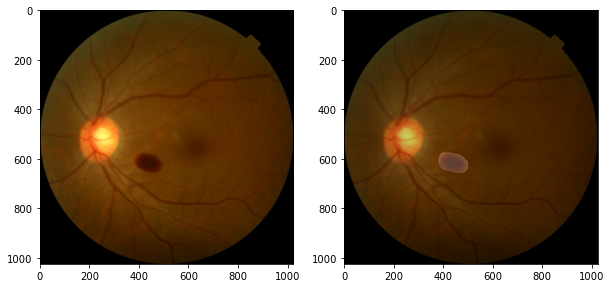

In [7]:
# Checking data
for nps in range(0,1):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(imgnpy[nps], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(imgnpy[nps], cmap='gray')
    plt.imshow(msknpy[nps], cmap='gray_r', alpha = 0.2)   